# Models Comparison for TinyML

In [134]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv

#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import sys
import seaborn as sbs

warnings.filterwarnings('ignore')

In [135]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

## Change 'chosenIndex' to change the chosen Test (s/s3/s6)

In [151]:
dataXPath = ['../data/X.pkl', '../data/XS3.pkl', '../data/XS6.pkl']
dataYPath = ['../data/y.pkl', '../data/yS3.pkl', '../data/yS6.pkl']
choosenIndex = 2

with open(dataXPath[choosenIndex], 'rb') as f:
    X = pickle.load(f)

with open(dataYPath[choosenIndex], 'rb') as f:
    y = pickle.load(f)

In [152]:
#X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
#y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

print(np.unique(y))

[2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000]


In [153]:
# Convert the labels in values like 0...n for the NN tests

labels = []
uniques = list(np.unique(y))

[labels.append(uniques.index(el)) for el in y]

y = np.array(labels)
print(y)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

## Model Spotting

In [155]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [156]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , Pipeline([('Scaler', StandardScaler()), ('SVC', SVC(gamma=0.05, random_state=seed))])))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [157]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,53 0,04
LR - 0,49 0,06
CART - 0,55 0,05
SVC - 0,47 0,05
RF - 0,64 0,04


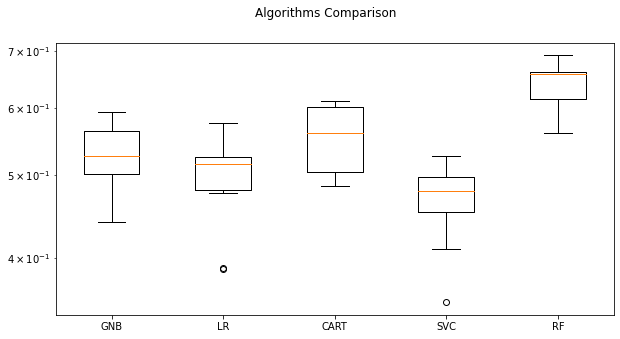

In [158]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_yscale('log')
ax.set_xticklabels(names)
plt.show()

# Valutazione dei modelli sul Test Set

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        20
           1       1.00      0.90      0.95        20
           2       0.18      0.10      0.13        20
           3       0.88      0.70      0.78        20
           4       0.37      0.50      0.43        20
           5       0.00      0.00      0.00        20
           6       0.79      0.95      0.86        20
           7       0.47      0.70      0.56        20
           8       0.54      0.70      0.61        20
           9       0.40      0.20      0.27        20
          10       0.50      0.75      0.60        20

    accuracy                           0.59       220
   macro avg       0.53      0.59      0.55       220
weighted avg       0.53      0.59      0.55       220

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.58      0.35      0.44    

# Valutazione Inferance Rate medio (|X_test| = 50/50/100)

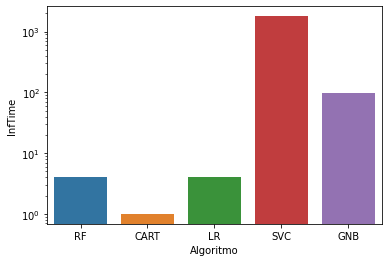

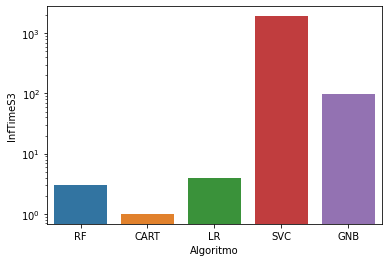

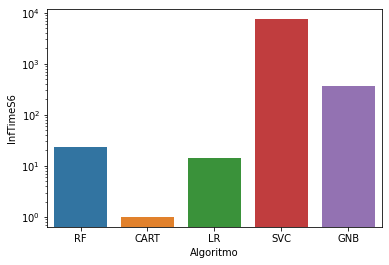

In [160]:
columns = ['InfTime', 'InfTimeS3', 'InfTimeS6']
for c in columns:
    csv = read_csv("InfTimeReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    g.set_yscale("log")
    plt.ylabel(c)
    plt.show()


# Memoria occupata

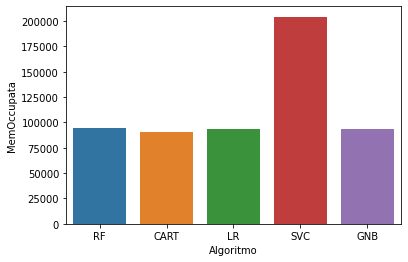

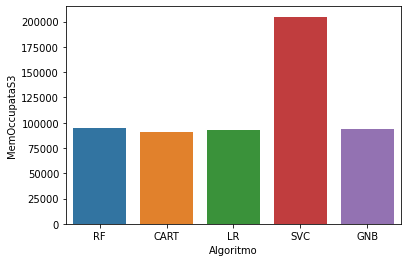

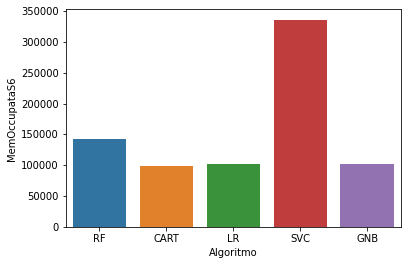

In [161]:
columns = ['MemOccupata', 'MemOccupataS3', 'MemOccupataS6']
for c in columns:   
    csv = read_csv("MemOccupationReport.csv")
    g = sbs.barplot(x=csv['Algoritmo'], y=csv[c])
    plt.ylabel(c)
    plt.show()

# Neural Network

In [162]:
def getNetwork(): 
    n = 100
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dense(np.unique(y).size * n, activation='relu'))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Cross-Validation NN

In [108]:
EPOCHS = 500
BATCH_SIZE = 8
num_folds = 10


kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_43 (Dense)             (None, 600)               19800     
_________________________________________________________________
dense_44 (Dense)             (None, 6)                 3606      
Total params: 24,462
Trainable params: 24,462
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
54/54 [==============================] - 0s 570us/step - loss: 1.2467 - accuracy: 0.3750
Epoch 2/500
54/54 [==============================] - 0s 510us/step - loss: 0.9166 - accuracy: 0.5532
Epoch 3/500
54/54 [==============================] - 0s 523us/step - loss: 0.7037 - accuracy: 0.7130
Epoch 4/500
54/54 [==============================] - 0s 570us/step - loss: 0

KeyboardInterrupt: 

# Train and Test

In [163]:
EPOCHS = 1400
BATCH_SIZE = 8

model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
print(classification_report(y_test, pred))

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_55 (Dense)             (None, 1100)              36300     
_________________________________________________________________
dense_56 (Dense)             (None, 11)                12111     
Total params: 49,467
Trainable params: 49,467
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1400
83/83 [==============================] - 0s 1ms/step - loss: 1.8209 - accuracy: 0.2227 - val_loss: 1.6424 - val_accuracy: 0.2500
Epoch 2/1400
83/83 [==============================] - 0s 837us/step - loss: 1.4755 - accuracy: 0.3727 - val_loss: 1.3442 - val_accuracy: 0.4500
Epoch 3/1400
83/83 [==============================] - 0s 785us/step - loss: 1.2806 - accuracy

83/83 [==============================] - 0s 783us/step - loss: 0.8372 - accuracy: 0.6485 - val_loss: 1.0991 - val_accuracy: 0.5773
Epoch 53/1400
83/83 [==============================] - 0s 774us/step - loss: 0.8261 - accuracy: 0.6530 - val_loss: 1.0718 - val_accuracy: 0.5636
Epoch 54/1400
83/83 [==============================] - 0s 781us/step - loss: 0.8391 - accuracy: 0.6455 - val_loss: 1.1462 - val_accuracy: 0.5682
Epoch 55/1400
83/83 [==============================] - 0s 793us/step - loss: 0.8282 - accuracy: 0.6561 - val_loss: 1.1305 - val_accuracy: 0.5000
Epoch 56/1400
83/83 [==============================] - 0s 789us/step - loss: 0.8249 - accuracy: 0.6394 - val_loss: 1.0782 - val_accuracy: 0.6318
Epoch 57/1400
83/83 [==============================] - 0s 765us/step - loss: 0.8387 - accuracy: 0.6182 - val_loss: 1.1406 - val_accuracy: 0.5091
Epoch 58/1400
83/83 [==============================] - 0s 792us/step - loss: 0.7974 - accuracy: 0.6742 - val_loss: 1.0794 - val_accuracy: 0.5136

83/83 [==============================] - 0s 782us/step - loss: 0.5439 - accuracy: 0.7894 - val_loss: 1.3436 - val_accuracy: 0.5773
Epoch 109/1400
83/83 [==============================] - 0s 782us/step - loss: 0.5505 - accuracy: 0.7848 - val_loss: 1.3306 - val_accuracy: 0.6091
Epoch 110/1400
83/83 [==============================] - 0s 772us/step - loss: 0.5958 - accuracy: 0.7439 - val_loss: 1.4485 - val_accuracy: 0.5318
Epoch 111/1400
83/83 [==============================] - 0s 768us/step - loss: 0.5578 - accuracy: 0.7727 - val_loss: 1.3807 - val_accuracy: 0.6182
Epoch 112/1400
83/83 [==============================] - 0s 788us/step - loss: 0.5454 - accuracy: 0.7924 - val_loss: 1.3201 - val_accuracy: 0.6273
Epoch 113/1400
83/83 [==============================] - 0s 783us/step - loss: 0.5354 - accuracy: 0.7818 - val_loss: 1.3362 - val_accuracy: 0.5727
Epoch 114/1400
83/83 [==============================] - 0s 779us/step - loss: 0.5514 - accuracy: 0.7727 - val_loss: 1.3901 - val_accuracy: 

83/83 [==============================] - 0s 766us/step - loss: 0.4156 - accuracy: 0.8379 - val_loss: 1.6851 - val_accuracy: 0.6545
Epoch 165/1400
83/83 [==============================] - 0s 819us/step - loss: 0.3878 - accuracy: 0.8379 - val_loss: 1.6760 - val_accuracy: 0.6545
Epoch 166/1400
83/83 [==============================] - 0s 751us/step - loss: 0.3743 - accuracy: 0.8636 - val_loss: 1.6744 - val_accuracy: 0.6318
Epoch 167/1400
83/83 [==============================] - 0s 786us/step - loss: 0.3395 - accuracy: 0.8758 - val_loss: 1.7696 - val_accuracy: 0.5773
Epoch 168/1400
83/83 [==============================] - 0s 766us/step - loss: 0.3916 - accuracy: 0.8485 - val_loss: 1.7539 - val_accuracy: 0.6500
Epoch 169/1400
83/83 [==============================] - 0s 767us/step - loss: 0.3985 - accuracy: 0.8318 - val_loss: 1.9246 - val_accuracy: 0.5455
Epoch 170/1400
83/83 [==============================] - 0s 767us/step - loss: 0.4128 - accuracy: 0.8348 - val_loss: 1.6707 - val_accuracy: 

83/83 [==============================] - 0s 793us/step - loss: 0.3357 - accuracy: 0.8621 - val_loss: 2.0685 - val_accuracy: 0.6545
Epoch 221/1400
83/83 [==============================] - 0s 819us/step - loss: 0.3268 - accuracy: 0.8697 - val_loss: 2.1842 - val_accuracy: 0.6682
Epoch 222/1400
83/83 [==============================] - 0s 769us/step - loss: 0.3014 - accuracy: 0.8803 - val_loss: 2.0934 - val_accuracy: 0.6818
Epoch 223/1400
83/83 [==============================] - 0s 791us/step - loss: 0.3012 - accuracy: 0.8955 - val_loss: 2.2225 - val_accuracy: 0.6409
Epoch 224/1400
83/83 [==============================] - 0s 778us/step - loss: 0.3002 - accuracy: 0.8848 - val_loss: 2.3331 - val_accuracy: 0.6273
Epoch 225/1400
83/83 [==============================] - 0s 781us/step - loss: 0.2967 - accuracy: 0.8773 - val_loss: 2.3282 - val_accuracy: 0.5682
Epoch 226/1400
83/83 [==============================] - 0s 783us/step - loss: 0.3328 - accuracy: 0.8636 - val_loss: 2.1176 - val_accuracy: 

83/83 [==============================] - 0s 777us/step - loss: 0.2572 - accuracy: 0.8985 - val_loss: 2.6944 - val_accuracy: 0.6545
Epoch 277/1400
83/83 [==============================] - 0s 783us/step - loss: 0.3261 - accuracy: 0.8773 - val_loss: 2.5783 - val_accuracy: 0.6364
Epoch 278/1400
83/83 [==============================] - 0s 790us/step - loss: 0.2411 - accuracy: 0.9106 - val_loss: 2.6067 - val_accuracy: 0.6409
Epoch 279/1400
83/83 [==============================] - 0s 760us/step - loss: 0.2897 - accuracy: 0.8909 - val_loss: 2.4559 - val_accuracy: 0.6682
Epoch 280/1400
83/83 [==============================] - 0s 781us/step - loss: 0.2901 - accuracy: 0.8924 - val_loss: 2.7018 - val_accuracy: 0.6136
Epoch 281/1400
83/83 [==============================] - 0s 781us/step - loss: 0.2833 - accuracy: 0.8727 - val_loss: 2.4432 - val_accuracy: 0.6636
Epoch 282/1400
83/83 [==============================] - 0s 765us/step - loss: 0.3274 - accuracy: 0.8667 - val_loss: 2.6400 - val_accuracy: 

83/83 [==============================] - 0s 787us/step - loss: 0.2263 - accuracy: 0.9197 - val_loss: 2.9298 - val_accuracy: 0.6545
Epoch 333/1400
83/83 [==============================] - 0s 779us/step - loss: 0.2088 - accuracy: 0.9212 - val_loss: 2.8428 - val_accuracy: 0.6773
Epoch 334/1400
83/83 [==============================] - 0s 874us/step - loss: 0.2188 - accuracy: 0.9136 - val_loss: 3.0408 - val_accuracy: 0.6045
Epoch 335/1400
83/83 [==============================] - 0s 769us/step - loss: 0.2954 - accuracy: 0.8727 - val_loss: 2.7717 - val_accuracy: 0.6545
Epoch 336/1400
83/83 [==============================] - 0s 771us/step - loss: 0.3127 - accuracy: 0.8803 - val_loss: 2.7999 - val_accuracy: 0.6409
Epoch 337/1400
83/83 [==============================] - 0s 766us/step - loss: 0.1987 - accuracy: 0.9333 - val_loss: 2.7529 - val_accuracy: 0.6909
Epoch 338/1400
83/83 [==============================] - 0s 758us/step - loss: 0.1726 - accuracy: 0.9409 - val_loss: 3.1118 - val_accuracy: 

83/83 [==============================] - 0s 784us/step - loss: 0.2027 - accuracy: 0.9121 - val_loss: 3.2252 - val_accuracy: 0.6455
Epoch 389/1400
83/83 [==============================] - 0s 772us/step - loss: 0.1997 - accuracy: 0.9242 - val_loss: 3.0099 - val_accuracy: 0.6818
Epoch 390/1400
83/83 [==============================] - 0s 769us/step - loss: 0.1701 - accuracy: 0.9288 - val_loss: 3.0651 - val_accuracy: 0.6091
Epoch 391/1400
83/83 [==============================] - 0s 789us/step - loss: 0.1717 - accuracy: 0.9318 - val_loss: 3.1187 - val_accuracy: 0.6682
Epoch 392/1400
83/83 [==============================] - 0s 795us/step - loss: 0.1312 - accuracy: 0.9576 - val_loss: 3.2179 - val_accuracy: 0.6409
Epoch 393/1400
83/83 [==============================] - 0s 822us/step - loss: 0.1620 - accuracy: 0.9364 - val_loss: 3.1119 - val_accuracy: 0.6818
Epoch 394/1400
83/83 [==============================] - 0s 780us/step - loss: 0.1551 - accuracy: 0.9394 - val_loss: 3.2190 - val_accuracy: 

83/83 [==============================] - 0s 789us/step - loss: 0.2664 - accuracy: 0.8985 - val_loss: 3.7788 - val_accuracy: 0.5955
Epoch 445/1400
83/83 [==============================] - 0s 770us/step - loss: 0.5136 - accuracy: 0.8409 - val_loss: 3.1541 - val_accuracy: 0.6636
Epoch 446/1400
83/83 [==============================] - 0s 765us/step - loss: 0.1663 - accuracy: 0.9485 - val_loss: 3.0709 - val_accuracy: 0.6773
Epoch 447/1400
83/83 [==============================] - 0s 770us/step - loss: 0.1469 - accuracy: 0.9439 - val_loss: 3.0088 - val_accuracy: 0.6682
Epoch 448/1400
83/83 [==============================] - 0s 763us/step - loss: 0.1114 - accuracy: 0.9606 - val_loss: 3.0503 - val_accuracy: 0.6909
Epoch 449/1400
83/83 [==============================] - 0s 775us/step - loss: 0.1467 - accuracy: 0.9439 - val_loss: 3.2140 - val_accuracy: 0.6636
Epoch 450/1400
83/83 [==============================] - 0s 772us/step - loss: 0.1107 - accuracy: 0.9606 - val_loss: 3.1187 - val_accuracy: 

83/83 [==============================] - 0s 783us/step - loss: 0.1349 - accuracy: 0.9409 - val_loss: 3.6023 - val_accuracy: 0.6636
Epoch 501/1400
83/83 [==============================] - 0s 782us/step - loss: 0.1168 - accuracy: 0.9485 - val_loss: 3.4785 - val_accuracy: 0.6591
Epoch 502/1400
83/83 [==============================] - 0s 789us/step - loss: 0.1392 - accuracy: 0.9500 - val_loss: 3.3800 - val_accuracy: 0.6955
Epoch 503/1400
83/83 [==============================] - 0s 782us/step - loss: 0.1162 - accuracy: 0.9530 - val_loss: 3.2744 - val_accuracy: 0.6455
Epoch 504/1400
83/83 [==============================] - 0s 746us/step - loss: 0.1229 - accuracy: 0.9515 - val_loss: 3.4213 - val_accuracy: 0.6955
Epoch 505/1400
83/83 [==============================] - 0s 778us/step - loss: 0.1260 - accuracy: 0.9530 - val_loss: 3.5796 - val_accuracy: 0.6545
Epoch 506/1400
83/83 [==============================] - 0s 786us/step - loss: 0.4053 - accuracy: 0.8409 - val_loss: 3.5193 - val_accuracy: 

83/83 [==============================] - 0s 789us/step - loss: 0.1190 - accuracy: 0.9515 - val_loss: 3.6143 - val_accuracy: 0.6818
Epoch 557/1400
83/83 [==============================] - 0s 769us/step - loss: 0.1635 - accuracy: 0.9364 - val_loss: 3.5916 - val_accuracy: 0.6636
Epoch 558/1400
83/83 [==============================] - 0s 784us/step - loss: 0.1557 - accuracy: 0.9348 - val_loss: 3.6582 - val_accuracy: 0.6682
Epoch 559/1400
83/83 [==============================] - 0s 841us/step - loss: 0.0948 - accuracy: 0.9667 - val_loss: 3.5302 - val_accuracy: 0.6773
Epoch 560/1400
83/83 [==============================] - 0s 781us/step - loss: 0.1191 - accuracy: 0.9545 - val_loss: 3.7262 - val_accuracy: 0.6682
Epoch 561/1400
83/83 [==============================] - 0s 776us/step - loss: 0.0715 - accuracy: 0.9758 - val_loss: 3.5780 - val_accuracy: 0.6727
Epoch 562/1400
83/83 [==============================] - 0s 778us/step - loss: 0.0946 - accuracy: 0.9682 - val_loss: 3.7230 - val_accuracy: 

83/83 [==============================] - 0s 774us/step - loss: 0.0819 - accuracy: 0.9682 - val_loss: 3.6520 - val_accuracy: 0.6864
Epoch 613/1400
83/83 [==============================] - 0s 764us/step - loss: 0.0645 - accuracy: 0.9742 - val_loss: 3.7970 - val_accuracy: 0.6636
Epoch 614/1400
83/83 [==============================] - 0s 750us/step - loss: 0.2027 - accuracy: 0.9167 - val_loss: 3.7899 - val_accuracy: 0.6455
Epoch 615/1400
83/83 [==============================] - 0s 785us/step - loss: 0.1700 - accuracy: 0.9333 - val_loss: 3.9226 - val_accuracy: 0.6227
Epoch 616/1400
83/83 [==============================] - 0s 836us/step - loss: 0.2317 - accuracy: 0.9106 - val_loss: 3.7391 - val_accuracy: 0.6818
Epoch 617/1400
83/83 [==============================] - 0s 772us/step - loss: 0.1216 - accuracy: 0.9515 - val_loss: 3.6196 - val_accuracy: 0.6636
Epoch 618/1400
83/83 [==============================] - 0s 783us/step - loss: 0.0791 - accuracy: 0.9712 - val_loss: 3.7382 - val_accuracy: 

83/83 [==============================] - 0s 775us/step - loss: 0.0583 - accuracy: 0.9773 - val_loss: 3.9124 - val_accuracy: 0.6500
Epoch 669/1400
83/83 [==============================] - 0s 775us/step - loss: 0.1150 - accuracy: 0.9530 - val_loss: 4.1154 - val_accuracy: 0.6318
Epoch 670/1400
83/83 [==============================] - 0s 767us/step - loss: 0.1602 - accuracy: 0.9333 - val_loss: 3.9315 - val_accuracy: 0.6636
Epoch 671/1400
83/83 [==============================] - 0s 769us/step - loss: 0.0827 - accuracy: 0.9636 - val_loss: 3.8357 - val_accuracy: 0.6591
Epoch 672/1400
83/83 [==============================] - 0s 790us/step - loss: 0.0782 - accuracy: 0.9758 - val_loss: 4.0167 - val_accuracy: 0.6318
Epoch 673/1400
83/83 [==============================] - 0s 774us/step - loss: 0.0802 - accuracy: 0.9727 - val_loss: 3.9842 - val_accuracy: 0.6273
Epoch 674/1400
83/83 [==============================] - 0s 786us/step - loss: 0.0904 - accuracy: 0.9697 - val_loss: 4.1780 - val_accuracy: 

83/83 [==============================] - 0s 777us/step - loss: 0.1409 - accuracy: 0.9455 - val_loss: 4.0851 - val_accuracy: 0.6318
Epoch 725/1400
83/83 [==============================] - 0s 776us/step - loss: 0.0912 - accuracy: 0.9712 - val_loss: 3.8803 - val_accuracy: 0.6545
Epoch 726/1400
83/83 [==============================] - 0s 750us/step - loss: 0.0992 - accuracy: 0.9606 - val_loss: 4.0809 - val_accuracy: 0.6455
Epoch 727/1400
83/83 [==============================] - 0s 878us/step - loss: 0.0645 - accuracy: 0.9788 - val_loss: 3.9814 - val_accuracy: 0.6727
Epoch 728/1400
83/83 [==============================] - 0s 796us/step - loss: 0.1332 - accuracy: 0.9500 - val_loss: 4.4161 - val_accuracy: 0.6091
Epoch 729/1400
83/83 [==============================] - 0s 812us/step - loss: 0.1169 - accuracy: 0.9606 - val_loss: 4.1958 - val_accuracy: 0.6727
Epoch 730/1400
83/83 [==============================] - 0s 776us/step - loss: 0.0679 - accuracy: 0.9758 - val_loss: 4.1278 - val_accuracy: 

83/83 [==============================] - 0s 778us/step - loss: 0.1084 - accuracy: 0.9530 - val_loss: 4.1280 - val_accuracy: 0.6227
Epoch 781/1400
83/83 [==============================] - 0s 851us/step - loss: 0.1275 - accuracy: 0.9515 - val_loss: 4.0678 - val_accuracy: 0.5773
Epoch 782/1400
83/83 [==============================] - 0s 748us/step - loss: 0.0949 - accuracy: 0.9682 - val_loss: 4.0546 - val_accuracy: 0.5955
Epoch 783/1400
83/83 [==============================] - 0s 786us/step - loss: 0.1147 - accuracy: 0.9515 - val_loss: 4.1728 - val_accuracy: 0.6227
Epoch 784/1400
83/83 [==============================] - 0s 792us/step - loss: 0.1087 - accuracy: 0.9576 - val_loss: 4.1522 - val_accuracy: 0.6500
Epoch 785/1400
83/83 [==============================] - 0s 781us/step - loss: 0.1103 - accuracy: 0.9636 - val_loss: 3.8462 - val_accuracy: 0.6591
Epoch 786/1400
83/83 [==============================] - 0s 778us/step - loss: 0.1153 - accuracy: 0.9652 - val_loss: 3.9072 - val_accuracy: 

83/83 [==============================] - 0s 789us/step - loss: 0.1970 - accuracy: 0.9303 - val_loss: 4.3555 - val_accuracy: 0.6682
Epoch 837/1400
83/83 [==============================] - 0s 751us/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 4.3985 - val_accuracy: 0.6364
Epoch 838/1400
83/83 [==============================] - 0s 780us/step - loss: 0.0760 - accuracy: 0.9667 - val_loss: 4.2215 - val_accuracy: 0.6591
Epoch 839/1400
83/83 [==============================] - 0s 751us/step - loss: 0.0487 - accuracy: 0.9879 - val_loss: 4.2785 - val_accuracy: 0.6545
Epoch 840/1400
83/83 [==============================] - 0s 759us/step - loss: 0.0373 - accuracy: 0.9894 - val_loss: 4.2851 - val_accuracy: 0.6864
Epoch 841/1400
83/83 [==============================] - 0s 774us/step - loss: 0.0549 - accuracy: 0.9773 - val_loss: 4.4076 - val_accuracy: 0.6455
Epoch 842/1400
83/83 [==============================] - 0s 749us/step - loss: 0.0798 - accuracy: 0.9667 - val_loss: 4.4246 - val_accuracy: 

83/83 [==============================] - 0s 777us/step - loss: 0.0661 - accuracy: 0.9803 - val_loss: 4.1387 - val_accuracy: 0.6773
Epoch 893/1400
83/83 [==============================] - 0s 775us/step - loss: 0.0573 - accuracy: 0.9773 - val_loss: 4.0735 - val_accuracy: 0.6864
Epoch 894/1400
83/83 [==============================] - 0s 794us/step - loss: 0.0330 - accuracy: 0.9894 - val_loss: 4.1520 - val_accuracy: 0.6773
Epoch 895/1400
83/83 [==============================] - 0s 787us/step - loss: 0.0457 - accuracy: 0.9818 - val_loss: 4.2894 - val_accuracy: 0.6545
Epoch 896/1400
83/83 [==============================] - 0s 773us/step - loss: 0.0532 - accuracy: 0.9803 - val_loss: 4.2488 - val_accuracy: 0.6773
Epoch 897/1400
83/83 [==============================] - 0s 807us/step - loss: 0.0503 - accuracy: 0.9848 - val_loss: 4.2170 - val_accuracy: 0.6500
Epoch 898/1400
83/83 [==============================] - 0s 785us/step - loss: 0.0655 - accuracy: 0.9742 - val_loss: 4.4348 - val_accuracy: 

83/83 [==============================] - 0s 781us/step - loss: 0.0499 - accuracy: 0.9803 - val_loss: 4.5412 - val_accuracy: 0.6273
Epoch 949/1400
83/83 [==============================] - 0s 771us/step - loss: 0.0894 - accuracy: 0.9576 - val_loss: 4.2670 - val_accuracy: 0.6364
Epoch 950/1400
83/83 [==============================] - 0s 779us/step - loss: 0.0631 - accuracy: 0.9773 - val_loss: 4.3202 - val_accuracy: 0.6545
Epoch 951/1400
83/83 [==============================] - 0s 785us/step - loss: 0.0451 - accuracy: 0.9848 - val_loss: 4.2052 - val_accuracy: 0.6773
Epoch 952/1400
83/83 [==============================] - 0s 776us/step - loss: 0.0343 - accuracy: 0.9894 - val_loss: 4.1834 - val_accuracy: 0.6773
Epoch 953/1400
83/83 [==============================] - 0s 775us/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 4.1551 - val_accuracy: 0.6636
Epoch 954/1400
83/83 [==============================] - 0s 775us/step - loss: 0.0626 - accuracy: 0.9758 - val_loss: 4.2047 - val_accuracy: 

83/83 [==============================] - 0s 773us/step - loss: 0.0435 - accuracy: 0.9833 - val_loss: 4.2560 - val_accuracy: 0.6864
Epoch 1005/1400
83/83 [==============================] - 0s 924us/step - loss: 0.0610 - accuracy: 0.9773 - val_loss: 4.4186 - val_accuracy: 0.6500
Epoch 1006/1400
83/83 [==============================] - 0s 836us/step - loss: 0.0744 - accuracy: 0.9742 - val_loss: 4.4868 - val_accuracy: 0.6273
Epoch 1007/1400
83/83 [==============================] - 0s 741us/step - loss: 0.0723 - accuracy: 0.9712 - val_loss: 4.3412 - val_accuracy: 0.6091
Epoch 1008/1400
83/83 [==============================] - 0s 774us/step - loss: 0.0538 - accuracy: 0.9833 - val_loss: 4.4131 - val_accuracy: 0.6455
Epoch 1009/1400
83/83 [==============================] - 0s 775us/step - loss: 0.0723 - accuracy: 0.9742 - val_loss: 4.4920 - val_accuracy: 0.6182
Epoch 1010/1400
83/83 [==============================] - 0s 797us/step - loss: 0.2469 - accuracy: 0.9242 - val_loss: 4.2259 - val_accu

Epoch 1060/1400
83/83 [==============================] - 0s 835us/step - loss: 0.0738 - accuracy: 0.9712 - val_loss: 4.4587 - val_accuracy: 0.6682
Epoch 1061/1400
83/83 [==============================] - 0s 777us/step - loss: 0.0502 - accuracy: 0.9803 - val_loss: 4.9022 - val_accuracy: 0.5045
Epoch 1062/1400
83/83 [==============================] - 0s 771us/step - loss: 0.3826 - accuracy: 0.8833 - val_loss: 4.4587 - val_accuracy: 0.6409
Epoch 1063/1400
83/83 [==============================] - 0s 775us/step - loss: 0.1022 - accuracy: 0.9576 - val_loss: 4.1587 - val_accuracy: 0.6682
Epoch 1064/1400
83/83 [==============================] - 0s 764us/step - loss: 0.0424 - accuracy: 0.9909 - val_loss: 4.3694 - val_accuracy: 0.6318
Epoch 1065/1400
83/83 [==============================] - 0s 768us/step - loss: 0.0441 - accuracy: 0.9818 - val_loss: 4.2469 - val_accuracy: 0.6591
Epoch 1066/1400
83/83 [==============================] - 0s 833us/step - loss: 0.0392 - accuracy: 0.9894 - val_loss: 4

Epoch 1116/1400
83/83 [==============================] - 0s 784us/step - loss: 0.0257 - accuracy: 0.9939 - val_loss: 4.4463 - val_accuracy: 0.6545
Epoch 1117/1400
83/83 [==============================] - 0s 757us/step - loss: 0.0908 - accuracy: 0.9606 - val_loss: 4.7107 - val_accuracy: 0.6182
Epoch 1118/1400
83/83 [==============================] - 0s 782us/step - loss: 0.1167 - accuracy: 0.9606 - val_loss: 4.3661 - val_accuracy: 0.6682
Epoch 1119/1400
83/83 [==============================] - 0s 787us/step - loss: 0.1045 - accuracy: 0.9606 - val_loss: 4.5780 - val_accuracy: 0.6318
Epoch 1120/1400
83/83 [==============================] - 0s 825us/step - loss: 0.0704 - accuracy: 0.9727 - val_loss: 4.7869 - val_accuracy: 0.6136
Epoch 1121/1400
83/83 [==============================] - 0s 778us/step - loss: 0.0419 - accuracy: 0.9848 - val_loss: 4.8355 - val_accuracy: 0.6318
Epoch 1122/1400
83/83 [==============================] - 0s 766us/step - loss: 0.1846 - accuracy: 0.9318 - val_loss: 5

Epoch 1172/1400
83/83 [==============================] - 0s 773us/step - loss: 0.0371 - accuracy: 0.9909 - val_loss: 4.4843 - val_accuracy: 0.6636
Epoch 1173/1400
83/83 [==============================] - 0s 822us/step - loss: 0.0380 - accuracy: 0.9864 - val_loss: 4.5388 - val_accuracy: 0.6773
Epoch 1174/1400
83/83 [==============================] - 0s 781us/step - loss: 0.0334 - accuracy: 0.9924 - val_loss: 4.4888 - val_accuracy: 0.6727
Epoch 1175/1400
83/83 [==============================] - 0s 761us/step - loss: 0.0727 - accuracy: 0.9727 - val_loss: 4.5547 - val_accuracy: 0.6727
Epoch 1176/1400
83/83 [==============================] - 0s 772us/step - loss: 0.0978 - accuracy: 0.9591 - val_loss: 4.7697 - val_accuracy: 0.6455
Epoch 1177/1400
83/83 [==============================] - 0s 750us/step - loss: 0.0577 - accuracy: 0.9758 - val_loss: 4.6105 - val_accuracy: 0.6500
Epoch 1178/1400
83/83 [==============================] - 0s 765us/step - loss: 0.0529 - accuracy: 0.9818 - val_loss: 4

Epoch 1228/1400
83/83 [==============================] - 0s 771us/step - loss: 0.0837 - accuracy: 0.9682 - val_loss: 4.9403 - val_accuracy: 0.6409
Epoch 1229/1400
83/83 [==============================] - 0s 785us/step - loss: 0.1298 - accuracy: 0.9545 - val_loss: 4.7115 - val_accuracy: 0.6818
Epoch 1230/1400
83/83 [==============================] - 0s 791us/step - loss: 0.0441 - accuracy: 0.9818 - val_loss: 4.6650 - val_accuracy: 0.6682
Epoch 1231/1400
83/83 [==============================] - 0s 761us/step - loss: 0.0271 - accuracy: 0.9924 - val_loss: 4.6798 - val_accuracy: 0.6545
Epoch 1232/1400
83/83 [==============================] - 0s 782us/step - loss: 0.0197 - accuracy: 0.9985 - val_loss: 4.6827 - val_accuracy: 0.6727
Epoch 1233/1400
83/83 [==============================] - 0s 774us/step - loss: 0.0231 - accuracy: 0.9909 - val_loss: 4.9147 - val_accuracy: 0.6364
Epoch 1234/1400
83/83 [==============================] - 0s 776us/step - loss: 0.0342 - accuracy: 0.9894 - val_loss: 4

Epoch 1284/1400
83/83 [==============================] - 0s 772us/step - loss: 0.0894 - accuracy: 0.9667 - val_loss: 5.1040 - val_accuracy: 0.6318
Epoch 1285/1400
83/83 [==============================] - 0s 773us/step - loss: 0.1349 - accuracy: 0.9515 - val_loss: 5.4073 - val_accuracy: 0.5591
Epoch 1286/1400
83/83 [==============================] - 0s 768us/step - loss: 0.1454 - accuracy: 0.9455 - val_loss: 4.9901 - val_accuracy: 0.6364
Epoch 1287/1400
83/83 [==============================] - 0s 780us/step - loss: 0.0857 - accuracy: 0.9652 - val_loss: 4.8202 - val_accuracy: 0.6727
Epoch 1288/1400
83/83 [==============================] - 0s 776us/step - loss: 0.0403 - accuracy: 0.9864 - val_loss: 4.7409 - val_accuracy: 0.6636
Epoch 1289/1400
83/83 [==============================] - 0s 805us/step - loss: 0.0350 - accuracy: 0.9879 - val_loss: 4.8389 - val_accuracy: 0.6500
Epoch 1290/1400
83/83 [==============================] - 0s 829us/step - loss: 0.0159 - accuracy: 0.9970 - val_loss: 4

Epoch 1340/1400
83/83 [==============================] - 0s 775us/step - loss: 0.0879 - accuracy: 0.9667 - val_loss: 5.2947 - val_accuracy: 0.6455
Epoch 1341/1400
83/83 [==============================] - 0s 763us/step - loss: 0.3067 - accuracy: 0.8833 - val_loss: 5.2125 - val_accuracy: 0.5909
Epoch 1342/1400
83/83 [==============================] - 0s 780us/step - loss: 0.2286 - accuracy: 0.9182 - val_loss: 4.9471 - val_accuracy: 0.6455
Epoch 1343/1400
83/83 [==============================] - 0s 776us/step - loss: 0.0621 - accuracy: 0.9833 - val_loss: 4.8285 - val_accuracy: 0.6500
Epoch 1344/1400
83/83 [==============================] - 0s 817us/step - loss: 0.0335 - accuracy: 0.9894 - val_loss: 4.7993 - val_accuracy: 0.6727
Epoch 1345/1400
83/83 [==============================] - 0s 746us/step - loss: 0.0411 - accuracy: 0.9879 - val_loss: 4.8859 - val_accuracy: 0.6409
Epoch 1346/1400
83/83 [==============================] - 0s 773us/step - loss: 0.0799 - accuracy: 0.9803 - val_loss: 4

Epoch 1396/1400
83/83 [==============================] - 0s 755us/step - loss: 0.1118 - accuracy: 0.9530 - val_loss: 5.1215 - val_accuracy: 0.6409
Epoch 1397/1400
83/83 [==============================] - 0s 789us/step - loss: 0.2019 - accuracy: 0.9379 - val_loss: 4.6751 - val_accuracy: 0.6682
Epoch 1398/1400
83/83 [==============================] - 0s 770us/step - loss: 0.0427 - accuracy: 0.9864 - val_loss: 4.8491 - val_accuracy: 0.6682
Epoch 1399/1400
83/83 [==============================] - 0s 797us/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 4.8394 - val_accuracy: 0.6727
Epoch 1400/1400
83/83 [==============================] - 0s 781us/step - loss: 0.0235 - accuracy: 0.9939 - val_loss: 4.8089 - val_accuracy: 0.6682
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.86      0.95      0.90        20
           2       0.56      0.50      0.53        20
           3       0.86      0.90      0.88     

# Export Models in C code

In [164]:
# Models in Pipeline
modelsInPipeline = []
modelsInPipeline.append('LR')
modelsInPipeline.append('SVC')

In [165]:
directories = ['s/', 's3/', 's6/']

# Neural network with TinyMLGen
with open('exportedModels/' + directories[choosenIndex] + 'NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = 'exportedModels/' + directories[choosenIndex]
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmpddveta27/assets


INFO:tensorflow:Assets written to: /tmp/tmpddveta27/assets
